# Technology News Trend Analyzer

This notebook analyzes technology news trends from the Phoronix dataset. It performs the following steps:
1. Loads and preprocesses article data.
2. Classifies articles into predefined technology categories.
3. Uses TF-IDF and K-Means clustering to identify hidden topics.
4. Displays the analysis through terminal output and visual plots.

1. Moch. Udhay Yunussabil	                163221004
2. Valiantino Ramandhika A.                 163221038
3. Patrick Andrasena Tumengkol              163221077

In [1]:
import pandas as pd
import nltk
import os
from datetime import datetime
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings('ignore')

In [2]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

## Define the Analyzer Class

The `TechNewsAnalyzer` class encapsulates all the functionality for loading, processing, and analyzing the data.

- Preprocessing
- clustering category
- analyze trend

In [3]:
class TechNewsAnalyzer:
    def __init__(self, csv_path="phoronix.csv"):
        """Initialize the Technology News Analysis System"""
        self.csv_path = csv_path
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.stop_words = set(nltk.corpus.stopwords.words('english'))
        self.vectorizer = TfidfVectorizer(max_features=1000)
        
        # Technology categories for classification
        self.tech_categories = {
            'AI/ML': ['artificial intelligence', 'machine learning', 'deep learning', 'neural network', 
                     'ai', 'ml', 'algorithm', 'automation'],
            'Hardware': ['cpu', 'gpu', 'processor', 'hardware', 'intel', 'amd', 'nvidia'],
            'Software': ['software', 'application', 'program', 'code', 'development'],
            'Security': ['security', 'hack', 'breach', 'malware', 'ransomware', 'encryption'],
            'Cloud': ['cloud', 'aws', 'azure', 'google cloud', 'saas', 'paas', 'iaas'],
            'Mobile': ['mobile', 'smartphone', 'ios', 'android', 'app', 'mobile app'],
            'Gaming': ['game', 'gaming', 'console', 'playstation', 'xbox', 'nintendo']
        }
        
        self.load_data()
    
    def load_data(self):
        """Load and prepare the dataset"""
        try:
            self.df = pd.read_csv(self.csv_path)
            print(f"Successfully loaded {len(self.df)} articles from {self.csv_path}")
            
            # Convert date column to datetime
            if 'created_at' in self.df.columns:
                self.df['created_at'] = pd.to_datetime(self.df['created_at'], errors='coerce')
            
            # Fill missing values
            self.df['title'] = self.df['title'].fillna('')
            # Note: The original file uses 'text', but the provided phoronix.csv has 'content'. 
            # Assuming 'content' should be used or aliased as 'text'.
            if 'content' in self.df.columns and 'text' not in self.df.columns:
                self.df['text'] = self.df['content'].fillna('')
            else:
                self.df['text'] = self.df['text'].fillna('')
            
            print("Data preparation completed.")
            return True
            
        except Exception as e:
            print(f"Error loading data: {e}")
            return False
    
    def preprocess_text(self, text: str) -> str:
        """Basic text preprocessing"""
        if not text or pd.isna(text):
            return ""
            
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs and special patterns
        text = re.sub(r'http[s]?://\S+', '', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # Tokenize and remove stopwords
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in self.stop_words and len(word) > 2]
        
        # Lemmatization
        processed_tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
        
        return ' '.join(processed_tokens)
    
    def detect_category(self, text: str) -> str:
        """Detect the primary technology category"""
        text_lower = text.lower()
        category_scores = {}
        
        for category, keywords in self.tech_categories.items():
            score = sum(1 for keyword in keywords if keyword.lower() in text_lower)
            if score > 0:
                category_scores[category] = score
        
        if category_scores:
            return max(category_scores, key=category_scores.get)
        return 'General'
    
    def analyze_trends(self, num_clusters: int = 5):
        """Analyze trends and display results"""
        if self.df.empty:
            print("No data available for analysis")
            return
        
        # Process all titles
        processed_titles = [self.preprocess_text(title) for title in self.df['title']]
        
        # Create TF-IDF matrix
        tfidf_matrix = self.vectorizer.fit_transform(processed_titles)
        
        # Perform clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(tfidf_matrix)
        
        # Add categories and clusters to dataframe
        self.df['category'] = self.df['title'].apply(self.detect_category)
        self.df['cluster'] = cluster_labels
        
        # Get category counts
        category_counts = self.df['category'].value_counts()
        
        # Display results in terminal
        print("\n" + "="*50)
        print("Technology News Trend Analysis")
        print("="*50 + "\n")
        
        # Category Analysis
        print("Category Distribution:")
        print("-"*20)
        for category, count in category_counts.items():
            print(f"{category}: {count} articles")
        print()
        
        # Cluster Analysis
        print("Cluster Analysis:")
        print("-"*20)
        for cluster_id in range(num_clusters):
            cluster_articles = self.df[self.df['cluster'] == cluster_id]
            print(f"\nCluster {cluster_id} ({len(cluster_articles)} articles):")
            
            # Get top titles for this cluster
            top_titles = cluster_articles['title'].head(5)
            for i, title in enumerate(top_titles, 1):
                print(f"{i}. {title}")
            
            # Get category distribution within cluster
            cluster_categories = cluster_articles['category'].value_counts()
            print("\nCategory distribution in this cluster:")
            for category, count in cluster_categories.items():
                print(f"  - {category}: {count} articles")
        
        # Create visualizations
        plt.style.use('seaborn-v0_8-whitegrid') # Use a compatible style
        
        # 1. Category Distribution Plot
        plt.figure(figsize=(12, 6))
        sns.barplot(x=category_counts.index, y=category_counts.values)
        plt.title('Distribution of Technology Categories')
        plt.xlabel('Category')
        plt.ylabel('Number of Articles')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # 2. Cluster Analysis Plot
        plt.figure(figsize=(12, 6))
        cluster_counts = self.df['cluster'].value_counts().sort_index()
        sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
        plt.title('Distribution of Article Clusters')
        plt.xlabel('Cluster ID')
        plt.ylabel('Number of Articles')
        plt.tight_layout()
        plt.show()

## Run Analysis

Now, we will create an instance of the `TechNewsAnalyzer` and run the trend analysis.

Initializing Technology News Analysis System...
Analyzing trends from Phoronix dataset

Successfully loaded 9242 articles from phoronix.csv
Data preparation completed.

Technology News Trend Analysis

Category Distribution:
--------------------
General: 5519 articles
Hardware: 2009 articles
AI/ML: 654 articles
Software: 408 articles
Gaming: 308 articles
Mobile: 236 articles
Security: 84 articles
Cloud: 24 articles

Cluster Analysis:
--------------------

Cluster 0 (2206 articles):
1. Btrfs Has Many Nice Improvements, Better Performance With Linux 5.11
2. NVIDIA 460.27.04 Linux Beta Driver Has Ray-Tracing, Many Other Changes
3. Linux 5.11 Begins Early Prepping Around PCI Express 6.0
4. The Most Popular NVIDIA Linux News + Milestones Of 2020
5. Radeon RX 6800 XT Seeing Some Slight Gains With Linux 5.11

Category distribution in this cluster:
  - General: 1218 articles
  - Hardware: 534 articles
  - AI/ML: 167 articles
  - Gaming: 149 articles
  - Software: 69 articles
  - Mobile: 44 arti

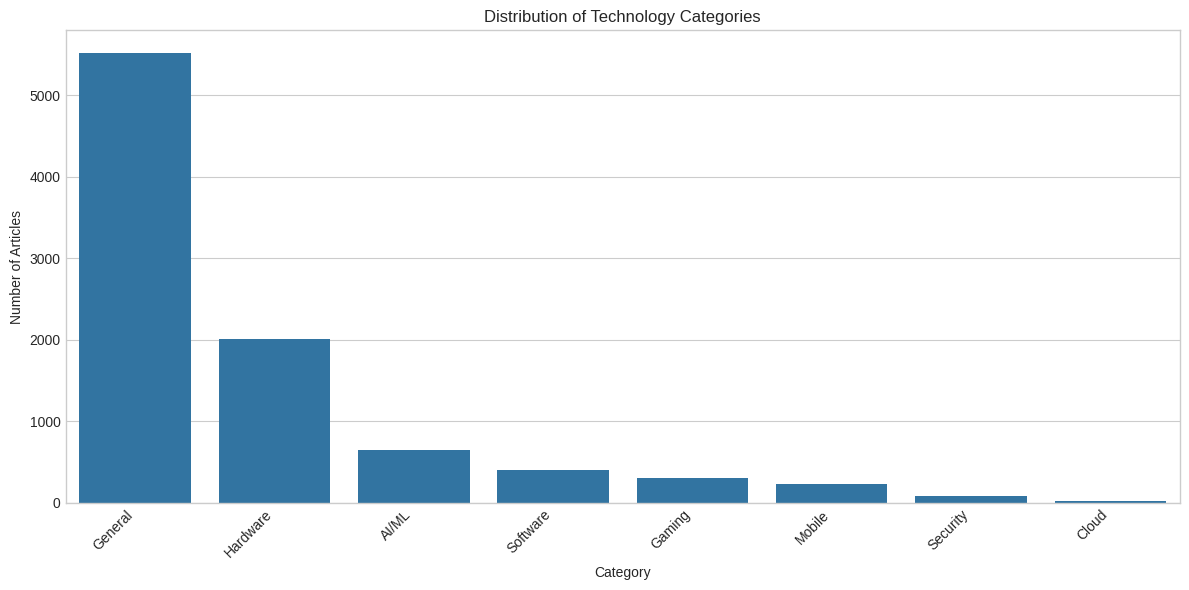

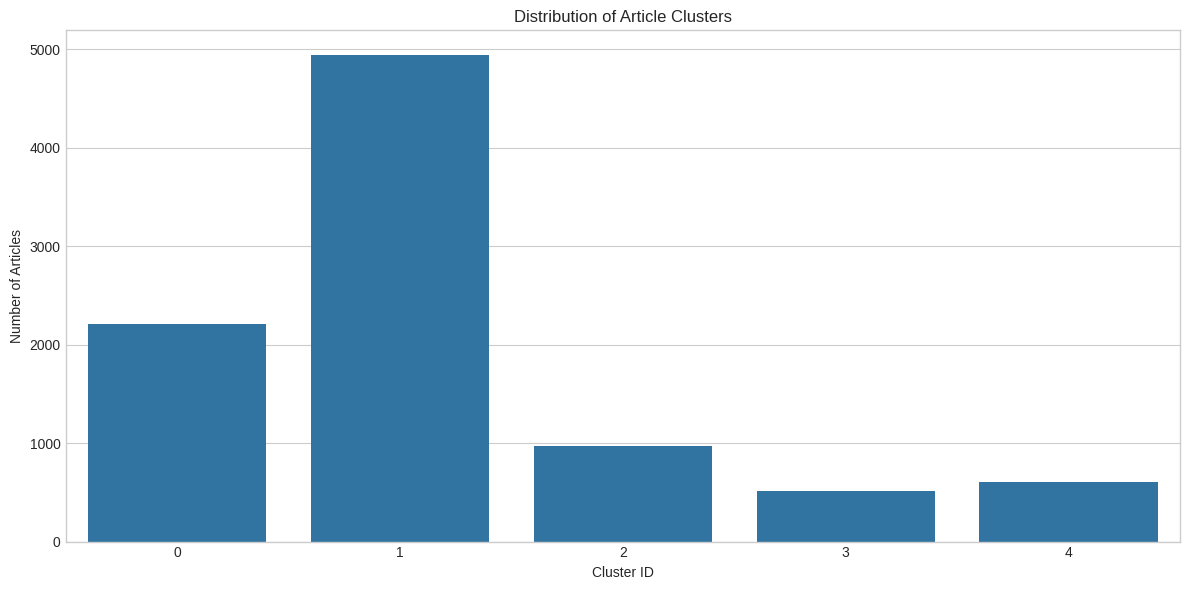


Analysis complete!


In [4]:
print("Initializing Technology News Analysis System...")
print("Analyzing trends from Phoronix dataset")
print()

analyzer = TechNewsAnalyzer()
analyzer.analyze_trends()

print("\nAnalysis complete!")